In [502]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import datetime, nltk
from fcmeans import FCM
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
import plotly as py
import plotly.graph_objs as go
from wordcloud import WordCloud, STOPWORDS
from sklearn import preprocessing
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from collections import Counter
import re
import lifetimes
from sklearn.decomposition import PCA

import datetime as dt

import lifetimes

from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter

from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions

In [503]:
data = pd.read_csv('data/dataset_1.csv')

In [504]:
df = data.copy(deep=True)

In [505]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


**Basic Clean Data**

In [506]:
df.dropna(axis=0, subset=['CustomerID'], inplace=True)

# Provides some information about the column type and the number of null values
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info= pd.concat([tab_info, pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'})])
tab_info=pd.concat([tab_info, pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.
                         rename(index={0:'null values (%)'})])
display(tab_info)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,object,float64,float64,object
null values (nb),0,0,0,0,0,0,0,0
null values (%),0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [507]:
print(f"Duplicate entries in the dataset: {df.duplicated().sum()}")

df.drop_duplicates(inplace=True)

print(f"Duplicate entries after the deletion operation in the dataset: {df.duplicated().sum()}")

Duplicate entries in the dataset: 5225
Duplicate entries after the deletion operation in the dataset: 0


In [508]:
#Convert data type to InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [509]:
temp = df.groupby(['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
temp['Order Cancelled'] = temp['InvoiceNo'].astype(str).apply(lambda x: x.startswith('C'))
total_cancelled_orders = temp['Order Cancelled'].sum()
print(f"Percentage of cancelled orders over total orders: {total_cancelled_orders / temp.shape[0]: .2f}")

Percentage of cancelled orders over total orders:  0.16


In [510]:
df_cleaned = df.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  df.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = df[(df['CustomerID'] == col['CustomerID']) &
                         (df['StockCode']  == col['StockCode']) & 
                         (df['InvoiceDate'] < col['InvoiceDate']) & 
                         (df['Quantity']   > 0)].copy()
    #_________________________________
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    #________________________________
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
    #______________________________________________________________
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break

In [511]:
print(f"entry_to_remove: {len(entry_to_remove)}")
print(f"doubtfull_entry: {len(doubtfull_entry)}")

entry_to_remove: 7521
doubtfull_entry: 1226


In [512]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("nb of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

nb of entries to delete: 48


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
77598,C542742,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,-94,2011-01-31 16:26:00,0.65000,15358.00000,United Kingdom,0
90444,C544038,22784,LANTERN CREAM GAZEBO,-4,2011-02-15 11:32:00,4.95000,14659.00000,United Kingdom,0
111968,C545852,22464,HANGING METAL HEART LANTERN,-5,2011-03-07 13:49:00,1.65000,14048.00000,United Kingdom,0
116064,C546191,47566B,TEA TIME PARTY BUNTING,-35,2011-03-10 10:57:00,0.70000,16422.00000,United Kingdom,0
132642,C547675,22263,FELT EGG COSY LADYBIRD,-49,2011-03-24 14:07:00,0.66000,17754.00000,United Kingdom,0


In [513]:
df_cleaned = df_cleaned[~df_cleaned['Quantity'] < 0]

remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0)]
print("number of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

number of entries to delete: 0


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled


In [514]:
df = df_cleaned.copy(deep=True)

**Price Distribution**

In [515]:
# Total products of each customer
nb_products_per_transaction = df.groupby(['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_transaction = nb_products_per_transaction.rename(columns={'InvoiceDate': 'Number of Products'})
display(nb_products_per_transaction.sort_values('CustomerID')[:5])
# E.g: Customer 1 buy 31 products in InvoiceNo 537626

,CustomerID,InvoiceNo,Number of Products
0,12346.00000,541431,1
1,12347.00000,537626,31
2,12347.00000,542237,29
3,12347.00000,549222,24
4,12347.00000,556201,18


In [516]:
pd.DataFrame([{
    'product': df['StockCode'].nunique(),
    'customer': df['CustomerID'].nunique(),
    'transaction': df['InvoiceNo'].nunique()
}], columns=['product', 'customer', 'transaction'], index=['quantity'])

,product,customer,transaction
quantity,3665,4339,18536


In [517]:
df_exp = df.copy(deep=True)
df_exp['TotalPrice'] = df_exp['UnitPrice'] * (df_exp['Quantity'] - df_exp['QuantityCanceled'])
df_exp.sort_values('CustomerID')[:10]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04000,12346.00000,United Kingdom,74215,0.00000
72246,542237,84625A,PINK NEW BAROQUECANDLESTICK CANDLE,24,2011-01-26 14:30:00,0.85000,12347.00000,Iceland,0,20.40000
14952,537626,22729,ALARM CLOCK BAKELIKE ORANGE,4,2010-12-07 14:57:00,3.75000,12347.00000,Iceland,0,15.00000
14953,537626,22212,FOUR HOOK WHITE LOVEBIRDS,6,2010-12-07 14:57:00,2.10000,12347.00000,Iceland,0,12.60000
14954,537626,85167B,BLACK GRAND BAROQUE PHOTO FRAME,30,2010-12-07 14:57:00,1.25000,12347.00000,Iceland,0,37.50000
14955,537626,21171,BATHROOM METAL SIGN,12,2010-12-07 14:57:00,1.45000,12347.00000,Iceland,0,17.40000
14956,537626,22195,LARGE HEART MEASURING SPOONS,12,2010-12-07 14:57:00,1.65000,12347.00000,Iceland,0,19.80000
14957,537626,84969,BOX OF 6 ASSORTED COLOUR TEASPOONS,6,2010-12-07 14:57:00,4.25000,12347.00000,Iceland,0,25.50000
14958,537626,84997C,BLUE 3 PIECE POLKADOT CUTLERY SET,6,2010-12-07 14:57:00,3.75000,12347.00000,Iceland,0,22.50000
14959,537626,84997B,RED 3 PIECE RETROSPOT CUTLERY SET,6,2010-12-07 14:57:00,3.75000,12347.00000,Iceland,0,22.50000


In [518]:
t = df_exp.groupby(['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = t.rename(columns={'TotalPrice': 'BasketPrice'})

df_exp['InvoiceDateInt'] = df_exp['InvoiceDate'].astype(np.int64)
t = df_exp.groupby(['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDateInt'].mean()
basket_price['InvoiceDate'] = t['InvoiceDateInt']
basket_price['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df_exp.drop(['InvoiceDateInt'], axis=1, inplace=True)

display(basket_price[:10])

,CustomerID,InvoiceNo,BasketPrice,InvoiceDate
0,12346.00000,541431,0.00000,2010-12-01 08:26:00
1,12347.00000,537626,711.79000,2010-12-01 08:26:00
2,12347.00000,542237,475.39000,2010-12-01 08:26:00
3,12347.00000,549222,636.25000,2010-12-01 08:26:00
4,12347.00000,556201,382.52000,2010-12-01 08:26:00
5,12347.00000,562032,584.91000,2010-12-01 08:26:00
6,12347.00000,573511,1294.32000,2010-12-01 08:26:00
7,12347.00000,581180,224.82000,2010-12-01 08:28:00
8,12348.00000,539318,892.80000,2010-12-01 08:28:00
9,12348.00000,541998,227.44000,2010-12-01 08:34:00


In [519]:
print(f'Total order in the basket price data frame: {basket_price.shape[0]}')

Total order in the basket price data frame: 18536


**Product Keywords Distribution**

In [520]:
# Noun if first 2 characters of the position tag is NN
is_noun = lambda pos: pos[:2]=="NN"

def keywords_inventory(dataframe, column="Description"):
    stemmer = nltk.SnowballStemmer("english")
    keyword_roots = dict() # Set of keywords for the same keyword root
    count_keywords = dict() # Count keyword roots
    
    category_keys = [] # 
    keyword_selects = dict() # root <-> keywords dictionary
    
    for s in dataframe[column]:
        # Check if description is null
        if pd.isnull(s): continue
        
        lines = s.lower()
        words = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(words) if is_noun(pos)]
        for n in nouns:
            n = n.lower()
            key_root = stemmer.stem(n)
            
            if key_root in keyword_roots:
                keyword_roots[key_root].add(n)
                count_keywords[key_root] += 1
            else:
                keyword_roots[key_root] = {n}
                count_keywords[key_root] = 1
        
    for s in keyword_roots.keys():
        if len(keyword_roots[s])>1:
            # Select the keyword with minimum length
            min_length = 1000
            for k in keyword_roots[s]:
                if len(k) < min_length:
                    min_length = len(k)
                    cat_key = k;
            keyword_selects[s] = cat_key
            category_keys.append(cat_key)
        else:
            keyword_selects[s] = list(keyword_roots[s])[0]
            category_keys.append(list(keyword_roots[s])[0])
        
    print(f"Number of categories in the variable {column}: {len(category_keys)}")
    return keyword_roots, count_keywords, keyword_selects, category_keys

In [521]:
df_products = pd.DataFrame({'Description': df_exp['Description'].unique()}, 
                           columns=['Description'])
display(df_products[:10])
df_products.shape

,Description
0,WHITE HANGING HEART T-LIGHT HOLDER
1,WHITE METAL LANTERN
2,CREAM CUPID HEARTS COAT HANGER
3,KNITTED UNION FLAG HOT WATER BOTTLE
4,RED WOOLLY HOTTIE WHITE HEART.
5,SET 7 BABUSHKA NESTING BOXES
6,GLASS STAR FROSTED T-LIGHT HOLDER
7,HAND WARMER UNION JACK
8,HAND WARMER RED POLKA DOT
9,ASSORTED COLOUR BIRD ORNAMENT


(3877, 1)

In [522]:
# Generating the keyword inventory
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

keyword_roots, count_keywords, keyword_selects, category_keys = \
keywords_inventory(df_products)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Number of categories in the variable Description: 1477


In [523]:
products_list = []

for k, v in count_keywords.items():
    products_list.append((keyword_selects[k], v))

products_list.sort(key=lambda x: x[1], reverse=True)
products_list[:10]

[('heart', 267),
 ('vintage', 210),
 ('set', 206),
 ('pink', 188),
 ('bag', 164),
 ('box', 153),
 ('glass', 149),
 ('christmas', 137),
 ('design', 128),
 ('candle', 121)]

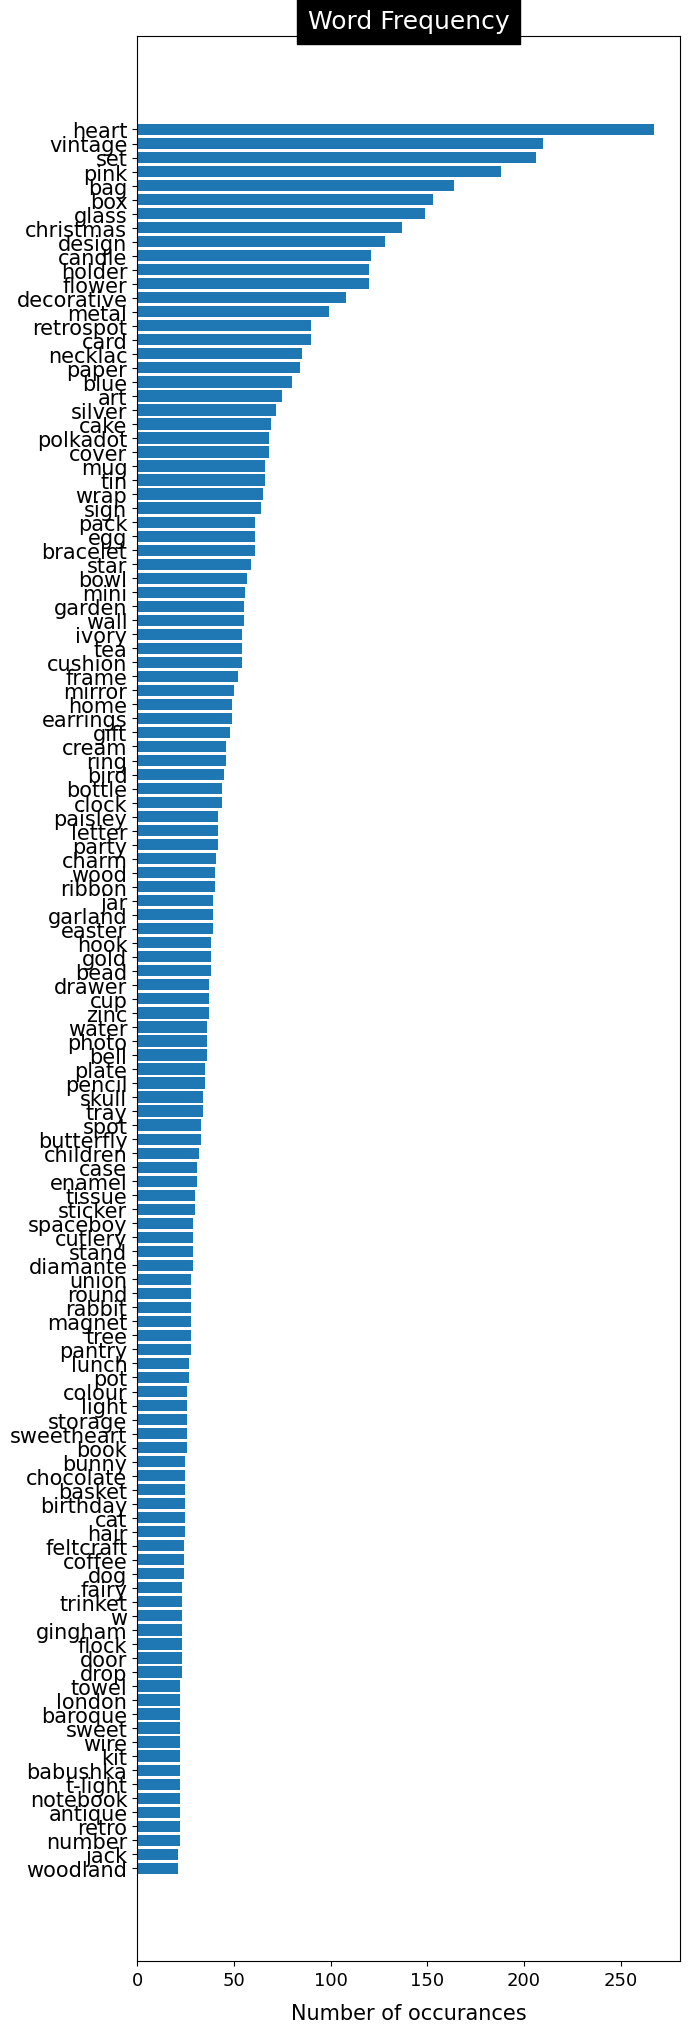

In [524]:
# Choose top N words
top_n = 125

# Configure the figure settings
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))

# x=>product keywords id, y=>product keyword count, x_label=>product keywords
y = [i[1] for i in products_list[:top_n]]
x = [k for k, i in enumerate(products_list[:top_n])]
x_label = [i[0] for i in products_list[:top_n]]

# Configure the x and y ticks fontsize
plt.xticks(fontsize=13)
plt.yticks(fontsize=15)

# Set y ticks with labels
plt.yticks(x, x_label)
# Set the x-labels
plt.xlabel("Number of occurances", fontsize=15, labelpad=10)

ax.barh(x, y, align='center')

# change the y-axis order
ax = plt.gca()
ax.invert_yaxis()

# Title with a bounding box of black background and 5 padding
plt.title("Word Frequency", bbox={'facecolor': 'k', 'pad': 5}, fontsize=18, color='w')

plt.show()

In [525]:
products_list = []

for k, v in count_keywords.items():
    word = keyword_selects[k]

    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word)<3 or v<13: continue
    if '+' in word or '/' in word: continue
    products_list.append([word, v])

products_list.sort(reverse=True, key=lambda x: x[1])
products_list[:10]

[['heart', 267],
 ['vintage', 210],
 ['set', 206],
 ['bag', 164],
 ['box', 153],
 ['glass', 149],
 ['christmas', 137],
 ['design', 128],
 ['candle', 121],
 ['holder', 120]]

In [526]:
X= pd.DataFrame()

for key, occurences in products_list:
    X.loc[:, key] = list(map(lambda x: int(key.upper() in x), df_products['Description']))

X[:10]

C:\Users\Admin\AppData\Local\Temp\ipykernel_13660\1151782331.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X.loc[:, key] = list(map(lambda x: int(key.upper() in x), df_products['Description']))
C:\Users\Admin\AppData\Local\Temp\ipykernel_13660\1151782331.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X.loc[:, key] = list(map(lambda x: int(key.upper() in x), df_products['Description']))
C:\Users\Admin\AppData\Local\Temp\ipykernel_13660\1151782331.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usuall

,heart,vintage,set,bag,box,glass,christmas,design,candle,holder,...,funky,tidy,plant,diner,house,square,craft,lace,wallet,point
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [527]:
# defining price range columns
threshold = [0, 1, 2, 3, 5, 10]
column_names = []
for i in range(1, len(threshold)+1):
    if i!=len(threshold):
        col_name = f"[{threshold[i-1]}, {threshold[i]})"
    else:
        col_name = f"[{threshold[i-1]}, INF)"

    X.loc[:, col_name] = 0
    column_names.append(col_name)

column_names

C:\Users\Admin\AppData\Local\Temp\ipykernel_13660\2985267938.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X.loc[:, col_name] = 0
C:\Users\Admin\AppData\Local\Temp\ipykernel_13660\2985267938.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X.loc[:, col_name] = 0
C:\Users\Admin\AppData\Local\Temp\ipykernel_13660\2985267938.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd

['[0, 1)', '[1, 2)', '[2, 3)', '[3, 5)', '[5, 10)', '[10, INF)']

In [528]:
# populating price range column
for i, product_name in enumerate(df_products['Description']):
    product_mean_price = df[df['Description'] == product_name]['UnitPrice'].mean()

    j = 1
    while j<=len(threshold):
        if j == len(threshold):
            if product_mean_price >= threshold[j-1]:
                break
        elif product_mean_price >= threshold[j-1] and product_mean_price < threshold[j]:
            break
        j+=1

    X.loc[i, column_names[j-1]] = 1

X[:5]

,heart,vintage,set,bag,box,glass,christmas,design,candle,holder,...,craft,lace,wallet,point,"[0, 1)","[1, 2)","[2, 3)","[3, 5)","[5, 10)","[10, INF)"
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


**Cluster of products**

In [529]:
matrix = X.values

for k in range(3, 10):
    kmeans = KMeans(n_clusters=k, init="k-means++", n_init=30, algorithm='elkan')
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    score = silhouette_score(matrix, clusters)

    print(f"Silhouette score for {k} cluster is {score}")

Silhouette score for 3 cluster is 0.10111124131467883
Silhouette score for 4 cluster is 0.12260542128782893
Silhouette score for 5 cluster is 0.14727180876518786
Silhouette score for 6 cluster is 0.15066997548207814
Silhouette score for 7 cluster is 0.15258264185699177
Silhouette score for 8 cluster is 0.14058779917765118
Silhouette score for 9 cluster is 0.12306785715830687


In [530]:
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.14:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)

    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 5 The average silhouette_score is : 0.14763791489515762


In [531]:
pd.Series(clusters).value_counts()

1    1012
2     961
4     672
3     625
0     607
Name: count, dtype: int64

**Word Cloud**

In [532]:
product_words = [word for (word, occurence) in products_list]

occurence = [dict() for _ in range(n_clusters)]

for i in range(n_clusters):
    product_cluster = df_products.loc[clusters == i]
    for word in product_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']: continue
        occurence[i][word] = sum(product_cluster.iloc[:, 0].str.contains(word.upper()))

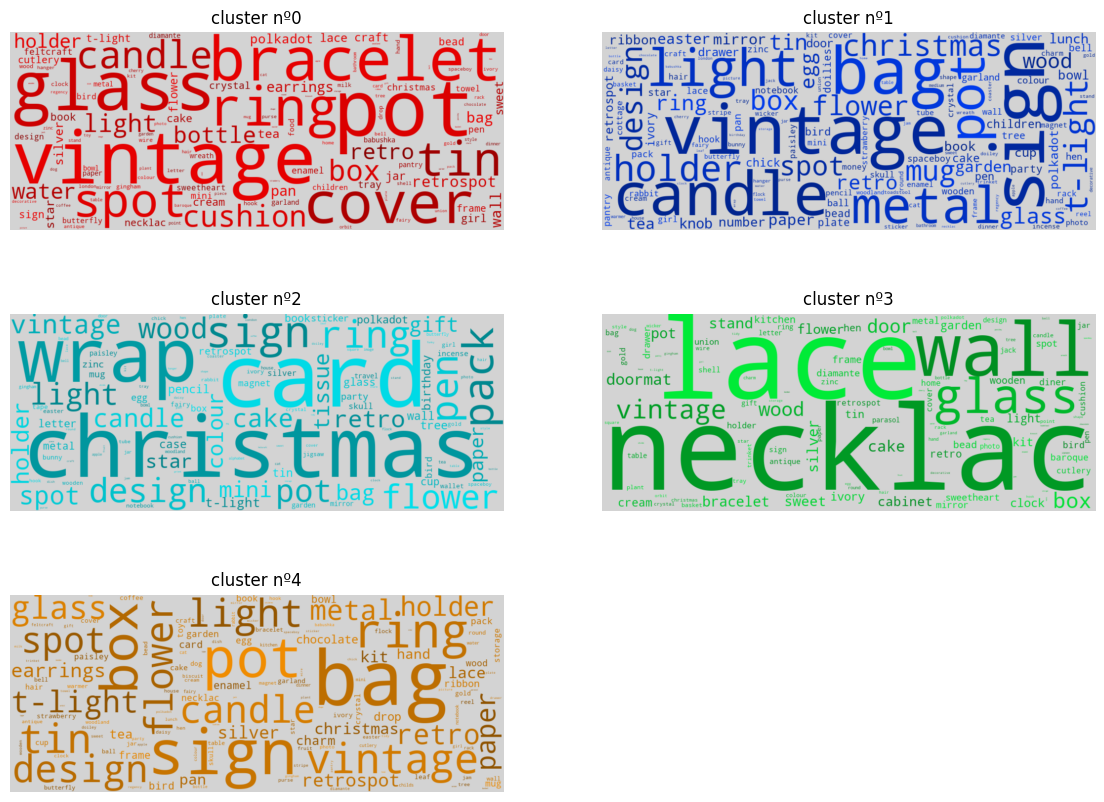

In [533]:
#________________________________________________________________________
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)
#________________________________________________________________________
def make_wordcloud(liste, increment):
    ax1 = fig.add_subplot(4,2,increment)
    words = dict()
    trunc_occurences = liste[0:150]
    for s in trunc_occurences:
        words[s[0]] = s[1]
    #________________________________________________________
    wordcloud = WordCloud(width=1000,height=400, background_color='lightgrey',
                          max_words=1628,relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster nº{}'.format(increment-1))
#________________________________________________________________________
fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
    list_cluster_occurences = occurence[i]

    tone = color[i] # define the color of the words
    liste = []
    for key, value in list_cluster_occurences.items():
        liste.append([key, value])
    liste.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(liste, i+1)

In [534]:
df_feature = df.copy(deep=True)

In [535]:
corresp = dict()
for key, val in zip (df_products['Description'].unique(), clusters):
    corresp[key] = val
#__________________________________________________________________________
df_feature['categ_product'] = df_feature.loc[:, 'Description'].map(corresp)

In [536]:
for i in range(n_clusters):
    col = 'categ_{}'.format(i)
    df_temp = df_feature[df_feature['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_feature.loc[:, col] = price_temp
    df_feature[col].fillna(0, inplace = True)
#__________________________________________________________________________________________________
df_feature[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4']][:10]

,InvoiceNo,Description,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,4,0.00000,0.00000,0.00000,0.00000,15.30000
1,536365,WHITE METAL LANTERN,0,20.34000,0.00000,0.00000,0.00000,0.00000
2,536365,CREAM CUPID HEARTS COAT HANGER,0,22.00000,0.00000,0.00000,0.00000,0.00000
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,0,20.34000,0.00000,0.00000,0.00000,0.00000
4,536365,RED WOOLLY HOTTIE WHITE HEART.,0,20.34000,0.00000,0.00000,0.00000,0.00000
5,536365,SET 7 BABUSHKA NESTING BOXES,3,0.00000,0.00000,0.00000,15.30000,0.00000
6,536365,GLASS STAR FROSTED T-LIGHT HOLDER,0,25.50000,0.00000,0.00000,0.00000,0.00000
7,536366,HAND WARMER UNION JACK,4,0.00000,0.00000,0.00000,0.00000,11.10000
8,536366,HAND WARMER RED POLKA DOT,1,0.00000,11.10000,0.00000,0.00000,0.00000
9,536367,ASSORTED COLOUR BIRD ORNAMENT,1,0.00000,54.08000,0.00000,0.00000,0.00000


*Grouping Products and Price*

In [537]:
df_feature['TotalPrice'] = df_feature['UnitPrice'] * (df_feature['Quantity'] - df_feature['QuantityCanceled'])
df_feature = df_feature[df_feature['TotalPrice'] > 0 ]

# Basket price for each purchase
temp = df_feature.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})

# Basket price for each purchase per category
for i in range(n_clusters):
    col = 'categ_{}'.format(i)
    temp = df_feature.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    basket_price.loc[:, col] = temp[col]

# Average time of purchase
df_feature['InvoiceDate_int'] = df_feature['InvoiceDate'].astype('int64')
temp = df_feature.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_feature.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

# Remove negative or zero basket price
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending = True)[:10]

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
0,12347.00000,537626,711.79000,293.35000,187.20000,23.40000,124.44000,83.40000,2010-12-07 14:57:00.000000000
1,12347.00000,542237,475.39000,169.20000,130.50000,84.34000,38.25000,53.10000,2011-01-26 14:29:59.999999744
2,12347.00000,549222,636.25000,115.00000,330.90000,81.00000,38.25000,71.10000,2011-04-07 10:43:00.000000000
3,12347.00000,556201,382.52000,168.76000,74.40000,41.40000,19.90000,78.06000,2011-06-09 13:01:00.000000000
4,12347.00000,562032,584.91000,158.16000,109.70000,61.30000,136.05000,119.70000,2011-08-02 08:48:00.000000000
5,12347.00000,573511,1294.32000,368.72000,203.30000,154.30000,132.10000,435.90000,2011-10-31 12:25:00.000000000
6,12347.00000,581180,224.82000,0.00000,100.80000,38.58000,30.00000,55.44000,2011-12-07 15:52:00.000000000
7,12348.00000,539318,892.80000,0.00000,174.00000,478.80000,240.00000,0.00000,2010-12-16 19:09:00.000000000
8,12348.00000,541998,227.44000,0.00000,0.00000,187.44000,40.00000,0.00000,2011-01-25 10:42:00.000000000
9,12348.00000,548955,367.00000,0.00000,310.00000,17.00000,40.00000,0.00000,2011-04-05 10:47:00.000000000


In [538]:
print(basket_price['InvoiceDate'].min(), '->',  basket_price['InvoiceDate'].max())

2010-12-01 08:26:00 -> 2011-12-09 12:50:00


In [539]:
train = basket_price[basket_price['InvoiceDate'].dt.date < datetime.date(2011,12,9)]
test         = basket_price[basket_price['InvoiceDate'].dt.date >= datetime.date(2010,12,1)]
basket_price = train.copy(deep = True)

In [540]:
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count',
                                                                                   'sum'])
for i in range(n_clusters):
    col = 'categ_{}'.format(i)
    transactions_per_user[col] = basket_price.groupby(by=['CustomerID'])[col].sum()

transactions_per_user.reset_index(drop = False, inplace = True)

transactions_per_user.sort_values('CustomerID', ascending = True)[:10]

,CustomerID,count,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347.00000,7,4310.00000,1273.19000,1136.80000,484.32000,518.99000,896.70000
1,12348.00000,4,1797.24000,0.00000,754.00000,683.24000,360.00000,0.00000
2,12349.00000,1,1757.55000,188.30000,465.86000,79.32000,808.85000,215.22000
3,12350.00000,1,334.40000,0.00000,162.00000,39.10000,40.00000,93.30000
4,12352.00000,7,2385.71000,348.35000,374.68000,31.00000,1534.55000,97.13000
5,12353.00000,1,89.00000,0.00000,11.60000,0.00000,59.70000,17.70000
6,12354.00000,1,1079.40000,212.65000,336.52000,161.38000,252.00000,116.85000
7,12355.00000,1,459.40000,116.10000,244.80000,0.00000,45.40000,53.10000
8,12356.00000,3,2811.43000,204.00000,788.95000,397.75000,1066.83000,353.90000
9,12357.00000,1,6207.67000,1759.88000,1146.90000,315.96000,2073.35000,911.58000


In [541]:
transactions_per_user = transactions_per_user[(transactions_per_user['count'] > 1)]


In [542]:
transactions_per_user.shape

(2837, 8)

**CLV-EDA**

In [543]:
pd.options.display.float_format = '{:.5f}'.format
# Import the CSV file into a DataFrame

dfnew = df_feature.copy()

dfnew['InvoiceDate'] = pd.to_datetime(dfnew['InvoiceDate']).dt.date
# Display the statistical summary of all columns
statistics = dfnew.describe([0.01,0.99]).T

# Print the statistics
print(statistics)


                        count        mean        std         min          1%  \
Quantity         390068.00000    12.64334   42.30114     1.00000     1.00000   
UnitPrice        390068.00000     3.06557   20.43616     0.00100     0.21000   
CustomerID       390068.00000 15289.76102 1713.38619 12347.00000 12415.00000   
QuantityCanceled 390068.00000     0.06334    3.08771     0.00000     0.00000   
categ_product    390068.00000     1.96624    1.34907     0.00000     0.00000   
categ_0          390068.00000     3.83131   33.47578     0.00000     0.00000   
categ_1          390068.00000     5.07066   27.15949     0.00000     0.00000   
categ_2          390068.00000     2.53910   15.56236     0.00000     0.00000   
categ_3          390068.00000     4.89974   44.88791     0.00000     0.00000   
categ_4          390068.00000     5.18428   35.64079     0.00000     0.00000   
TotalPrice       390068.00000    21.52509   70.85221     0.00100     0.55000   

                         50%         99

In [544]:
dfnew.dtypes

InvoiceNo            object
StockCode            object
Description          object
Quantity              int64
InvoiceDate          object
UnitPrice           float64
CustomerID          float64
Country              object
QuantityCanceled      int64
categ_product         int32
categ_0             float64
categ_1             float64
categ_2             float64
categ_3             float64
categ_4             float64
TotalPrice          float64
dtype: object

In [545]:
dfnew['InvoiceNo'] = dfnew['InvoiceNo'].astype(int)

In [546]:
dfnew.describe()

,InvoiceNo,Quantity,UnitPrice,CustomerID,QuantityCanceled,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4,TotalPrice
count,390068.00000,390068.00000,390068.00000,390068.00000,390068.00000,390068.00000,390068.00000,390068.00000,390068.00000,390068.00000,390068.00000,390068.00000
mean,560608.66788,12.64334,3.06557,15289.76102,0.06334,1.96624,3.83131,5.07066,2.53910,4.89974,5.18428,21.52509
std,13091.80270,42.30114,20.43616,1713.38619,3.08771,1.34907,33.47578,27.15949,15.56236,44.88791,35.64079,70.85221
min,536365.00000,1.00000,0.00100,12347.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00100
25%,549241.00000,2.00000,1.25000,13956.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,4.95000
50%,561885.00000,6.00000,1.95000,15152.00000,0.00000,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,11.90000
75%,572073.00000,12.00000,3.75000,16794.00000,0.00000,3.00000,0.00000,1.69000,0.00000,0.00000,0.00000,19.80000
max,581587.00000,4800.00000,8142.75000,18287.00000,960.00000,4.00000,7144.72000,6539.40000,3096.00000,8142.75000,4992.00000,8142.75000


**RFM**

In [547]:
clv = lifetimes.utils.summary_data_from_transaction_data(dfnew,'CustomerID','InvoiceDate','TotalPrice')

In [548]:
clv.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12347.00000,6.00000,365.00000,367.00000,599.70167
12348.00000,3.00000,283.00000,358.00000,301.48000
12349.00000,0.00000,0.00000,18.00000,0.00000
12350.00000,0.00000,0.00000,310.00000,0.00000
12352.00000,5.00000,260.00000,296.00000,417.84200


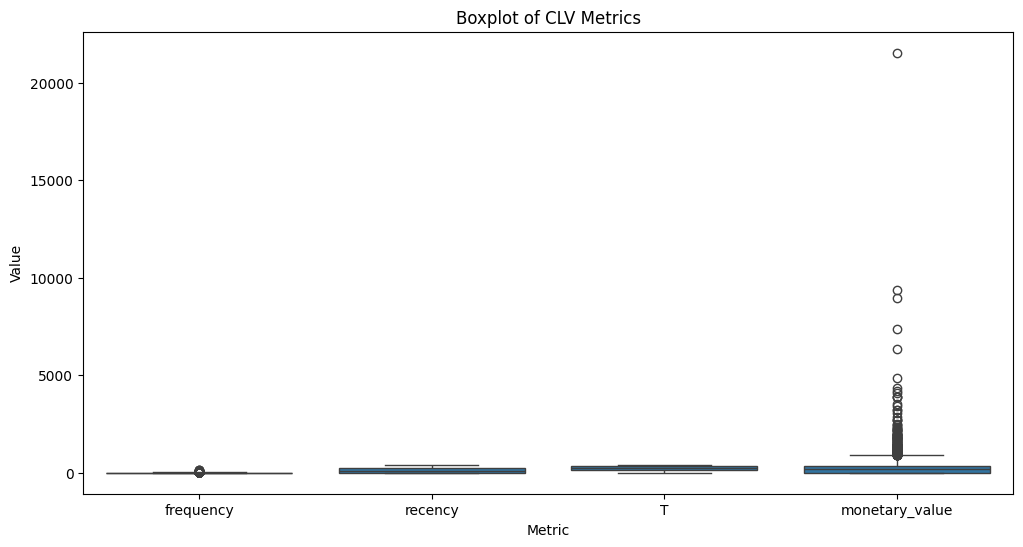

In [549]:

# Melt the dataframe to long format for seaborn
clv_melted = clv.reset_index().melt(id_vars=['CustomerID'], value_vars=['frequency', 'recency', 'T', 'monetary_value'])

# Plotting the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='variable', y='value', data=clv_melted)
plt.title('Boxplot of CLV Metrics')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.show()

In [550]:
clv.describe()

,frequency,recency,T,monetary_value
count,4327.00000,4327.00000,4327.00000,4327.00000
mean,2.85533,130.78484,223.00532,263.47885
std,5.92723,132.17245,117.79298,543.18172
min,0.00000,0.00000,0.00000,0.00000
25%,0.00000,0.00000,113.00000,0.00000
50%,1.00000,93.00000,249.00000,174.02000
75%,3.00000,252.00000,326.00000,354.15250
max,130.00000,373.00000,373.00000,21535.90000


count   4327.00000
mean       2.85533
std        5.92723
min        0.00000
25%        0.00000
50%        1.00000
75%        3.00000
max      130.00000
Name: frequency, dtype: float64
0.35659810492257915


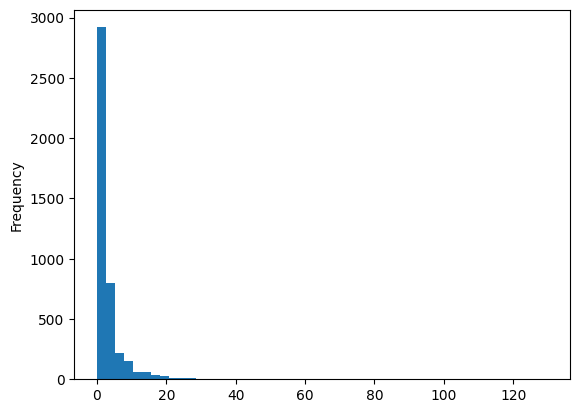

In [551]:
clv['frequency'].plot(kind='hist', bins=50)
print(clv['frequency'].describe())
# frequency=0 means no repeated purchase. 35.7% customers left after one purchase.
print(sum(clv['frequency'] == 0)/float(len(clv)))

**BG/NBD model**

In [552]:
from lifetimes import BetaGeoFitter

# penalizer_coef: regularization, to prevent overfitting especially when the dataset is small, can set 0 when dataset is large enough
bgf = BetaGeoFitter(penalizer_coef=0.0)

# fit BG model on the whole data
bgf.fit(clv['frequency'], clv['recency'], clv['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4327 subjects, a: 0.00, alpha: 69.11, b: 6.90, r: 0.83>


In [553]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.82632,0.02681,0.77376,0.87887
alpha,69.11160,2.62363,63.96928,74.25391
a,0.00317,0.01022,-0.01686,0.02320
b,6.90043,24.03154,-40.20138,54.00224


In [554]:
clv["expected_purc_1_month"] = bgf.conditional_expected_number_of_purchases_up_to_time(30,
                                                        clv['frequency'],
                                                        clv['recency'],
                                                        clv['T'])

clv["expected_purc_3_month"] = bgf.conditional_expected_number_of_purchases_up_to_time(120,
                                                        clv['frequency'],
                                                        clv['recency'],
                                                        clv['T'])

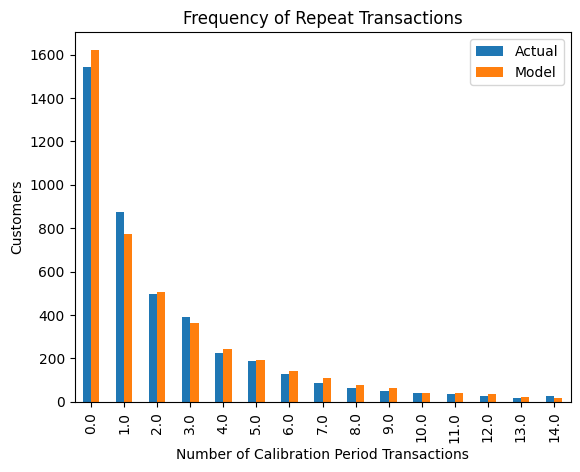

In [555]:
plot_period_transactions(bgf, max_frequency=15)
display()

<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

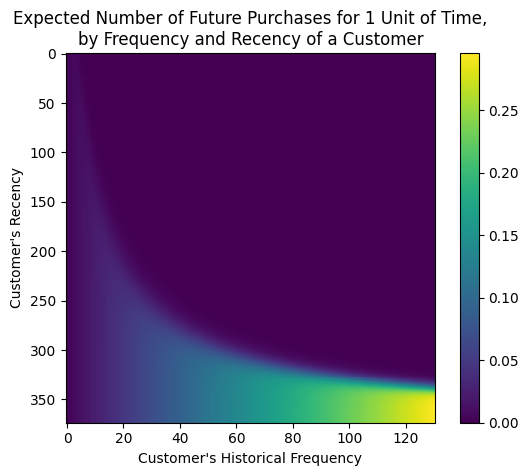

In [556]:
plot_frequency_recency_matrix(bgf)

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

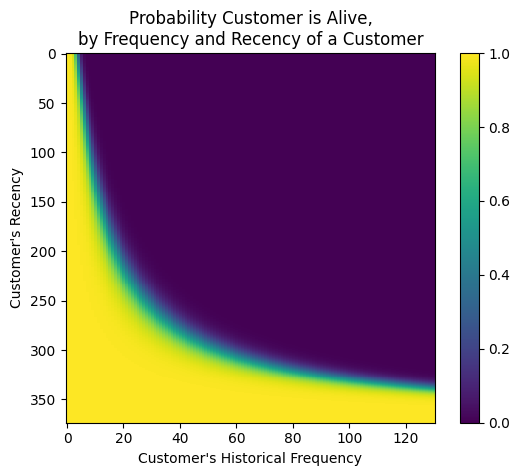

In [557]:
plot_probability_alive_matrix(bgf)


Split data for testing

In [558]:
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from sklearn.metrics import mean_absolute_error, mean_squared_error

summary_cal_holdout = calibration_and_holdout_data(dfnew, 'CustomerID', 'InvoiceDate',
                                        calibration_period_end='2011-08-31',
                                        observation_period_end='2012-01-01' )

In [559]:
def find_boundaries(df, variable,q1=0.05,q2=0.95):

    # the boundaries are the quantiles

    lower_boundary = df[variable].quantile(q1)
    upper_boundary = df[variable].quantile(q2)

    return upper_boundary, lower_boundary

def capping_outliers(df,variable):
    upper_boundary,lower_boundary =  find_boundaries(df,variable)
    df[variable] = np.where(df[variable] > upper_boundary, upper_boundary,
                       np.where(df[variable] < lower_boundary, lower_boundary, df[variable]))

capping_outliers(summary_cal_holdout,'frequency_cal')
capping_outliers(summary_cal_holdout,'frequency_holdout')

In [560]:
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12347.00000,4.00000,238.00000,267.00000,2.00000,123.00000
12348.00000,2.00000,110.00000,258.00000,1.00000,123.00000
12350.00000,0.00000,0.00000,210.00000,0.00000,123.00000
12352.00000,2.00000,34.00000,196.00000,3.00000,123.00000
12353.00000,0.00000,0.00000,104.00000,0.00000,123.00000


<Axes: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

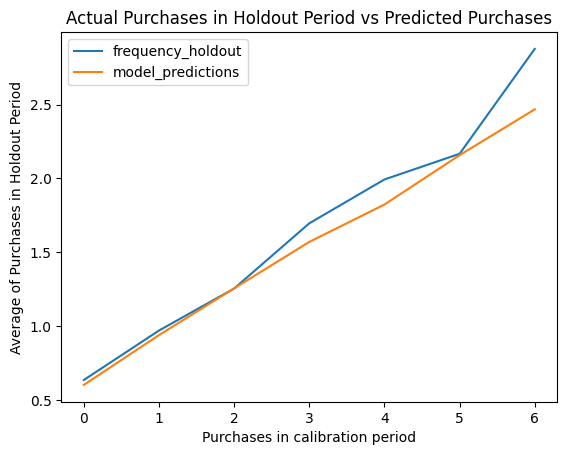

In [561]:
bgf2 = BetaGeoFitter(penalizer_coef=0.0)
bgf2.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf2, summary_cal_holdout)

In [562]:
summary_cal_holdout['predicted_purchases'] = bgf2.conditional_expected_number_of_purchases_up_to_time(100, summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])

In [563]:
from sklearn.metrics import mean_squared_error, r2_score

def smape(y_true, y_pred):
    difference = abs(y_true - y_pred)
    denominator = (abs(y_true) + abs(y_pred))/2
    return np.mean(np.where(denominator==0, 0, difference/denominator))

In [564]:
print('RMSE: ', mean_squared_error(summary_cal_holdout['frequency_holdout'], summary_cal_holdout['predicted_purchases'])**(1/2))
print('SMAPE', smape(summary_cal_holdout['frequency_holdout'], summary_cal_holdout['predicted_purchases']))
print('R2: ', r2_score(summary_cal_holdout['frequency_holdout'], summary_cal_holdout['predicted_purchases']))

RMSE:  1.2665488562586524
SMAPE 1.207948045672735
R2:  0.2786818187509319


In [565]:
clv[['frequency', 'monetary_value']].corr()


,frequency,monetary_value
frequency,1.00000,0.23954
monetary_value,0.23954,1.00000


**Remove Customer with no Repeated Purchase (frequency = 0)**

In [566]:
clv.head()

,frequency,recency,T,monetary_value,expected_purc_1_month,expected_purc_3_month
CustomerID,,,,,,
12347.00000,6.00000,365.00000,367.00000,599.70167,0.46942,1.87734
12348.00000,3.00000,283.00000,358.00000,301.48000,0.26854,1.07401
12349.00000,0.00000,0.00000,18.00000,0.00000,0.28453,1.13772
12350.00000,0.00000,0.00000,310.00000,0.00000,0.06539,0.26152
12352.00000,5.00000,260.00000,296.00000,417.84200,0.47844,1.91336


In [567]:
clv = clv[clv['frequency'] > 0]

In [568]:
clvcopy = clv.copy()

In [569]:
# Handling Outliers
def find_boundaries(df, variable,q1=0.05,q2=0.95):

    # the boundaries are the quantiles

    lower_boundary = df[variable].quantile(q1)
    upper_boundary = df[variable].quantile(q2)

    return upper_boundary, lower_boundary

def capping_outliers(df,variable):
    upper_boundary,lower_boundary =  find_boundaries(df,variable)
    df[variable] = np.where(df[variable] > upper_boundary, upper_boundary,
                       np.where(df[variable] < lower_boundary, lower_boundary, df[variable]))
    
    capping_outliers(clvcopy,'monetary_value')
    capping_outliers(clvcopy,'frequency')

BG/NBD for CLV calculation

In [570]:
bgf3 = BetaGeoFitter(penalizer_coef=0.0)

# fit BG model on the whole data
bgf3.fit(clvcopy['frequency'], clvcopy['recency'], clvcopy['T'])

<lifetimes.BetaGeoFitter: fitted with 2784 subjects, a: 0.01, alpha: 109.35, b: 0.15, r: 1.94>

**Gamma-Gamma modell**

In [571]:
ggf = GammaGammaFitter(penalizer_coef=0.0)
ggf.fit(clvcopy['frequency'], clvcopy['monetary_value'])
     

<lifetimes.GammaGammaFitter: fitted with 2784 subjects, p: 2.09, q: 3.53, v: 492.64>

In [572]:
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,2.09107,0.11118,1.87315,2.30899
q,3.53294,0.14503,3.24868,3.81720
v,492.63843,43.64640,407.09149,578.18537


**New BG/NBD model test**

c:\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


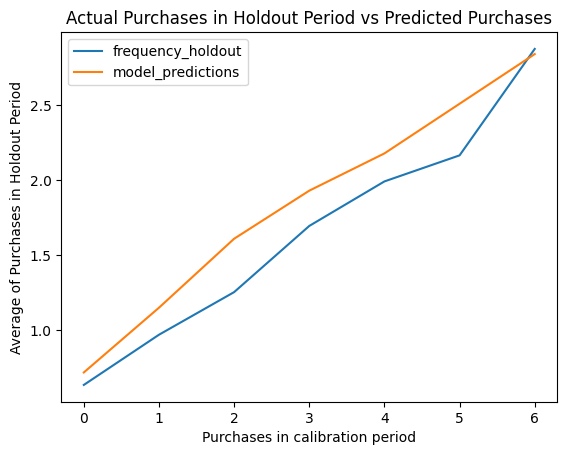

In [573]:
plot_calibration_purchases_vs_holdout_purchases(bgf3, summary_cal_holdout)
display()

**Check GG model errors**

In [923]:
#Compare predicted monetary avgs vs actual monetary avgs
predict_monetary = ggf.conditional_expected_average_profit(clvcopy['frequency'], clvcopy['monetary_value'])
clvcopy['predicted_monetary'] = predict_monetary

actual_monetary = clvcopy['monetary_value']

#Visualize distribution plot
import plotly.figure_factory as ff

x3= predict_monetary
x4= actual_monetary

hist_data2 = [x3, x4]
groups2 = ['Prediction', 'Actual']

In [924]:
clv['retention'] = bgf3.conditional_probability_alive(clvcopy['frequency'], clvcopy['recency'],clvcopy['T'])
clv['churn'] = 1 - bgf3.conditional_probability_alive(clvcopy['frequency'], clvcopy['recency'],clvcopy['T'])

clv["expected_average_profit"] = ggf.conditional_expected_average_profit(clvcopy['frequency'], clvcopy['monetary_value'])

clv['expected_clv'] = clv['expected_average_profit'] * clv['expected_purc_3_month']
                                          
clv['weeksfrom_lastpurchase'] = clvcopy['T'] - clvcopy['recency']

In [925]:
analyze = clv.copy()
analyze.reset_index(inplace=True)
analyze

,CustomerID,frequency,recency,T,monetary_value,expected_purc_1_month,expected_purc_3_month,retention,churn,expected_average_profit,expected_clv,weeksfrom_lastpurchase
0,12347.00000,6.00000,365.00000,367.00000,599.70167,0.46942,1.87734,0.99834,0.00166,567.28212,1064.97927,2.00000
1,12348.00000,3.00000,283.00000,358.00000,301.48000,0.26854,1.07401,0.99094,0.00906,331.74422,356.29585,75.00000
2,12352.00000,5.00000,260.00000,296.00000,417.84200,0.47844,1.91336,0.99621,0.00379,415.66877,795.32410,36.00000
3,12356.00000,2.00000,303.00000,325.00000,269.90500,0.21503,0.85999,0.99123,0.00877,321.50361,276.48911,22.00000
4,12358.00000,1.00000,149.00000,150.00000,683.20000,0.24992,0.99946,0.94659,0.05341,531.73789,531.45106,1.00000
...,...,...,...,...,...,...,...,...,...,...,...,...
2779,18272.00000,5.00000,244.00000,246.00000,484.83200,0.55448,2.21738,0.99793,0.00207,469.59457,1041.26943,2.00000
2780,18273.00000,2.00000,255.00000,257.00000,76.50000,0.25988,1.03934,0.99269,0.00731,201.05129,208.95977,2.00000
2781,18282.00000,1.00000,119.00000,126.00000,77.84000,0.28065,1.12233,0.94254,0.05746,257.98187,289.54146,7.00000
2782,18283.00000,13.00000,334.00000,337.00000,149.00615,1.02109,4.08339,0.99925,0.00075,170.97073,698.13943,3.00000


In [926]:
analyze.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,2784.00000,15280.46767,1718.17886,12347.00000,13811.75000,15239.50000,16778.25000,18287.00000
frequency,2784.00000,4.43786,6.89819,1.00000,1.00000,3.00000,5.00000,130.00000
recency,2784.00000,203.27083,111.42600,1.00000,105.75000,211.00000,301.25000,373.00000
T,2784.00000,260.01580,101.53514,9.00000,197.00000,284.00000,358.00000,373.00000
monetary_value,2784.00000,409.50897,631.51332,1.00000,184.32500,304.49111,448.49917,21535.90000
expected_purc_1_month,2784.00000,0.47448,0.48401,0.12230,0.22352,0.35512,0.55183,8.87619
expected_purc_3_month,2784.00000,1.89744,1.93544,0.48915,0.89395,1.42011,2.20668,35.49481
retention,2784.00000,0.93745,0.11723,0.18912,0.92977,0.99032,0.99685,0.99992
churn,2784.00000,0.06255,0.11723,0.00008,0.00315,0.00968,0.07023,0.81088
expected_average_profit,2784.00000,418.20219,432.30853,47.18735,272.96429,339.44934,433.69382,9961.75006


In [927]:
group1 = transactions_per_user.copy(deep=True)
group1.head()

,CustomerID,count,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347.00000,7,4310.00000,1273.19000,1136.80000,484.32000,518.99000,896.70000
1,12348.00000,4,1797.24000,0.00000,754.00000,683.24000,360.00000,0.00000
4,12352.00000,7,2385.71000,348.35000,374.68000,31.00000,1534.55000,97.13000
8,12356.00000,3,2811.43000,204.00000,788.95000,397.75000,1066.83000,353.90000
10,12358.00000,2,1168.06000,15.00000,74.16000,0.00000,1061.20000,17.70000


In [928]:
group1.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,2837.00000,15290.70673,1718.71121,12347.00000,13817.00000,15260.00000,16791.00000,18287.00000
count,2837.00000,5.94642,8.94285,2.00000,2.00000,4.00000,6.00000,204.00000
sum,2837.00000,2768.46402,10256.66201,6.90000,605.12000,1130.57000,2369.16000,279765.02000
categ_0,2837.00000,493.08433,2042.97678,0.00000,69.05000,169.90000,400.50000,59238.01000
categ_1,2837.00000,650.51828,2499.67519,0.00000,122.40000,274.40000,594.50000,101077.12000
categ_2,2837.00000,321.99520,1126.61715,0.00000,45.27000,125.43000,298.49000,37267.59000
categ_3,2837.00000,629.90973,4194.87426,0.00000,71.40000,197.65000,474.60000,202618.94000
categ_4,2837.00000,672.95649,2781.18798,0.00000,93.54000,216.60000,543.93000,76290.21000


In [929]:
analyze = pd.merge(analyze, group1[['CustomerID', 'sum', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']], on='CustomerID', how='left')

display(analyze[:5])

,CustomerID,frequency,recency,T,monetary_value,expected_purc_1_month,expected_purc_3_month,retention,churn,expected_average_profit,expected_clv,weeksfrom_lastpurchase,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347.00000,6.00000,365.00000,367.00000,599.70167,0.46942,1.87734,0.99834,0.00166,567.28212,1064.97927,2.00000,4310.00000,1273.19000,1136.80000,484.32000,518.99000,896.70000
1,12348.00000,3.00000,283.00000,358.00000,301.48000,0.26854,1.07401,0.99094,0.00906,331.74422,356.29585,75.00000,1797.24000,0.00000,754.00000,683.24000,360.00000,0.00000
2,12352.00000,5.00000,260.00000,296.00000,417.84200,0.47844,1.91336,0.99621,0.00379,415.66877,795.32410,36.00000,2385.71000,348.35000,374.68000,31.00000,1534.55000,97.13000
3,12356.00000,2.00000,303.00000,325.00000,269.90500,0.21503,0.85999,0.99123,0.00877,321.50361,276.48911,22.00000,2811.43000,204.00000,788.95000,397.75000,1066.83000,353.90000
4,12358.00000,1.00000,149.00000,150.00000,683.20000,0.24992,0.99946,0.94659,0.05341,531.73789,531.45106,1.00000,1168.06000,15.00000,74.16000,0.00000,1061.20000,17.70000


In [931]:
analyze.shape

(2784, 18)

**Customer Segmentation**

In [932]:
segment_customer = analyze.copy(deep=True)
display(segment_customer[:3])

segment_customer_skewed = segment_customer.copy()

,CustomerID,frequency,recency,T,monetary_value,expected_purc_1_month,expected_purc_3_month,retention,churn,expected_average_profit,expected_clv,weeksfrom_lastpurchase,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347.00000,6.00000,365.00000,367.00000,599.70167,0.46942,1.87734,0.99834,0.00166,567.28212,1064.97927,2.00000,4310.00000,1273.19000,1136.80000,484.32000,518.99000,896.70000
1,12348.00000,3.00000,283.00000,358.00000,301.48000,0.26854,1.07401,0.99094,0.00906,331.74422,356.29585,75.00000,1797.24000,0.00000,754.00000,683.24000,360.00000,0.00000
2,12352.00000,5.00000,260.00000,296.00000,417.84200,0.47844,1.91336,0.99621,0.00379,415.66877,795.32410,36.00000,2385.71000,348.35000,374.68000,31.00000,1534.55000,97.13000


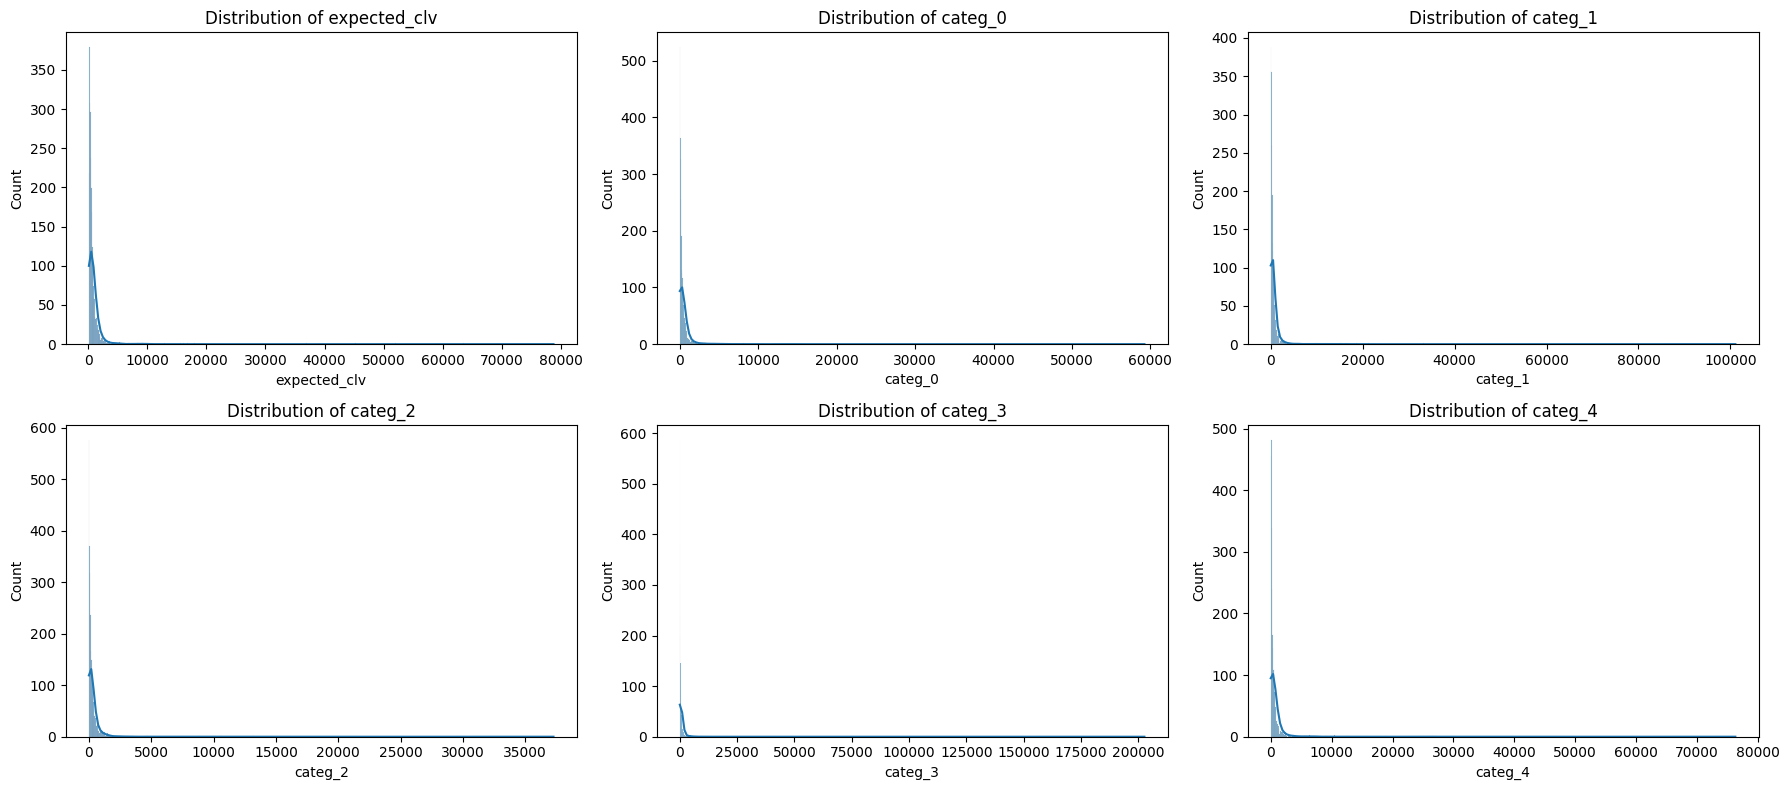

In [966]:
# Assuming segment_customer is your DataFrame
columns_to_plot = [ 'expected_clv', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']

# Calculate the number of rows and columns for subplots
num_columns = 3
num_rows = (len(columns_to_plot) + num_columns - 1) // num_columns

fig, ax = plt.subplots(num_rows, num_columns, figsize=(18, num_rows * 4))

# Flatten the axes array for easy iteration
ax = ax.flatten()

# Plot distributions for each column
for i, column in enumerate(columns_to_plot):
    sns.histplot(segment_customer[column], kde=True, ax=ax[i])
    ax[i].set_title(f'Distribution of {column}')

# Remove any empty subplots
for j in range(i+1, len(ax)):
    fig.delaxes(ax[j])

plt.tight_layout()
plt.show()

expected_clv    0
categ_0         1
categ_1         1
categ_2         1
categ_3         1
categ_4         1
dtype: int64
expected_clv    0
categ_0         0
categ_1         0
categ_2         0
categ_3         0
categ_4         0
dtype: int64


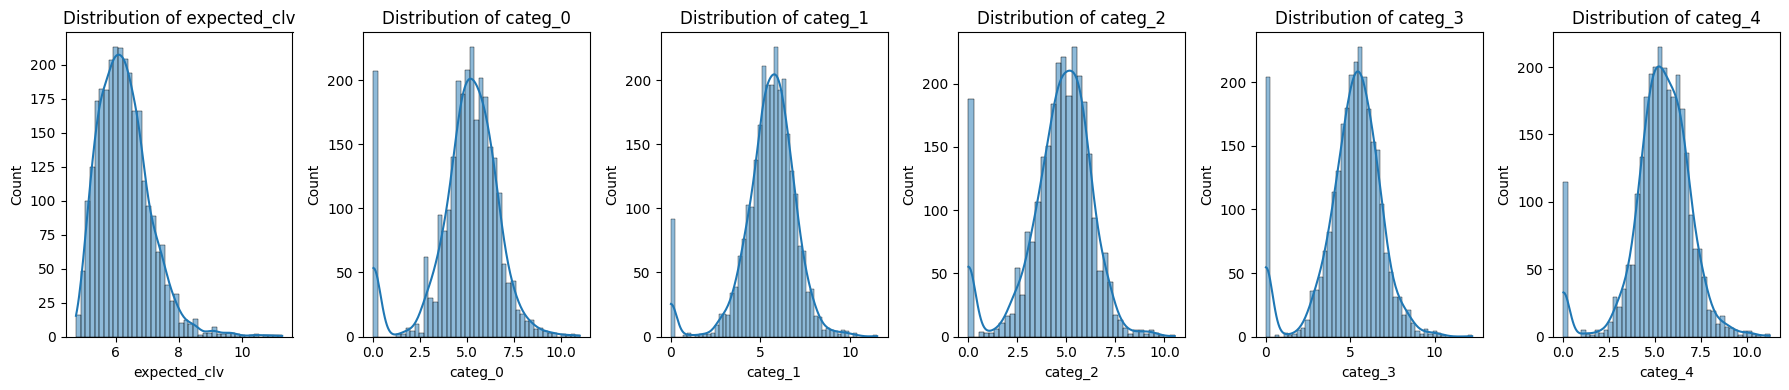

In [967]:
# Create skewed DataFrame
segment_customer_skewed = pd.DataFrame()
# Update the column names in segment_customer_skewed
segment_customer_skewed['expected_clv'] = np.log(segment_customer['expected_clv'] + 1)
segment_customer_skewed['categ_0'] = np.log(segment_customer['categ_0'] + 1)
segment_customer_skewed['categ_1'] = np.log(segment_customer['categ_1'] + 1)
segment_customer_skewed['categ_2'] = np.log(segment_customer['categ_2'] + 1)
segment_customer_skewed['categ_3'] = np.log(segment_customer['categ_3'] + 1)
segment_customer_skewed['categ_4'] = np.log(segment_customer['categ_4'] + 1)



# Check for null values
print(segment_customer_skewed.isnull().sum())

# Fill null values with column means
segment_customer_skewed.fillna(segment_customer_skewed.mean(), inplace=True)

# Check again for null values
print(segment_customer_skewed.isnull().sum())

# List of columns to plot
columns_to_plot = [ 'expected_clv', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']

# Calculate the number of rows and columns for subplots
num_columns = 6
num_rows = (len(columns_to_plot) + num_columns - 1) // num_columns

fig, ax = plt.subplots(num_rows, num_columns, figsize=(18, num_rows * 4))

# Flatten the axes array for easy iteration
ax = ax.flatten()

# Plot distributions for each column
for i, column in enumerate(columns_to_plot):
    sns.histplot(segment_customer_skewed[column], ax=ax[i], kde=True)
    ax[i].set_title(f'Distribution of {column}')

# Remove any empty subplots
for j in range(i + 1, len(ax)):
    fig.delaxes(ax[j])

# Adjust layout
plt.tight_layout()
plt.show()

In [968]:
# Start scale
scaler = StandardScaler()
scaler.fit(segment_customer_skewed)

segment_customer_skewed = scaler.transform(segment_customer_skewed)

pd.DataFrame(segment_customer_skewed).head()

,0,1,2,3,4,5
0,0.83593,1.21753,0.99095,0.90018,0.64447,0.89598
1,-0.48642,-2.66429,0.72851,1.09577,0.45239,-3.16878
2,0.48312,0.51501,0.28187,-0.64809,1.21441,-0.42722
3,-0.79222,0.22561,0.75746,0.78830,1.02321,0.34125
4,-0.00382,-1.15904,-0.74780,-2.62153,1.02043,-1.41819


**Choose optimal cluster**

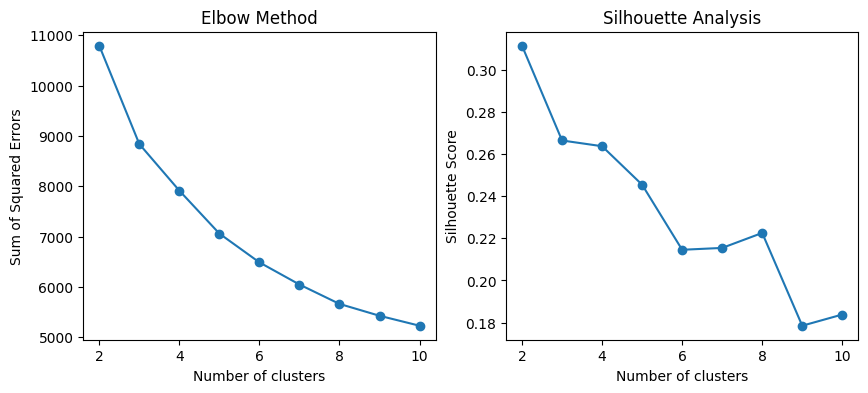

In [969]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1)
    
    sse = []
    silhouette_scores = []
    
    for k in iters:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(data, kmeans.labels_))
        
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(10, 4))
    
    ax1.plot(iters, sse, '-o')
    ax1.set_xlabel('Number of clusters')
    ax1.set_ylabel('Sum of Squared Errors')
    ax1.set_title('Elbow Method')
    
    ax2.plot(iters, silhouette_scores, '-o')
    ax2.set_xlabel('Number of clusters')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Analysis')
    
    plt.show()

# Finding the optimal number of clusters
find_optimal_clusters(segment_customer_skewed, max_k=10)

In [975]:
from sklearn.metrics import davies_bouldin_score
# Data (assuming segment_customer_skewed is already defined as before)
data_array = segment_customer_skewed



# 1. K-means Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(data_array)
kmeans_silhouette = silhouette_score(data_array, kmeans_labels)

# 2. Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=4)
hierarchical_labels = hierarchical.fit_predict(data_array)
hierarchical_silhouette = silhouette_score(data_array, hierarchical_labels)

# 3. Fuzzy C-means Clustering
fcm = FCM(n_clusters=4, random_state=42)
fcm.fit(data_array)
fcm_labels = fcm.predict(data_array)
fcm_silhouette = silhouette_score(data_array, fcm_labels)

# Compare the Clustering Results
comparison = pd.DataFrame({
    'Method': ['K-means', 'Hierarchical', 'Fuzzy C-means'],
    'Silhouette Score': [kmeans_silhouette, hierarchical_silhouette, fcm_silhouette]
})

print(comparison)

          Method  Silhouette Score
0        K-means           0.26378
1   Hierarchical           0.17555
2  Fuzzy C-means           0.15897


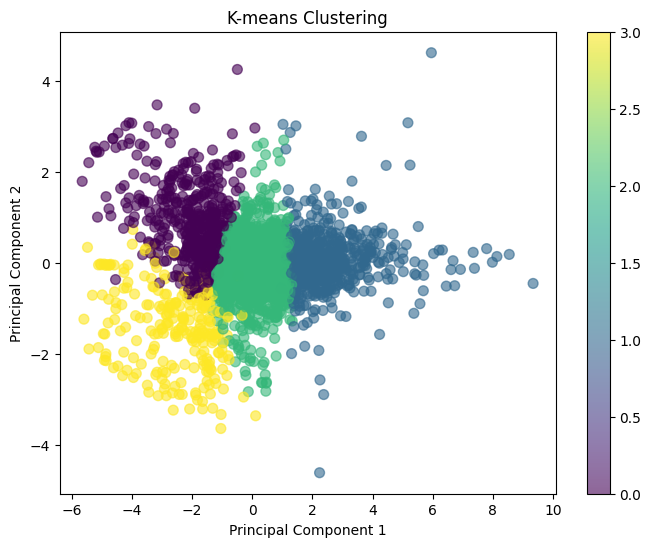

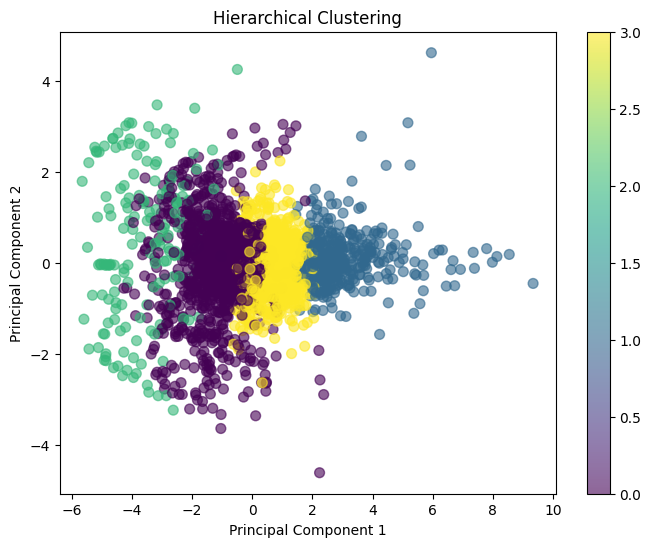

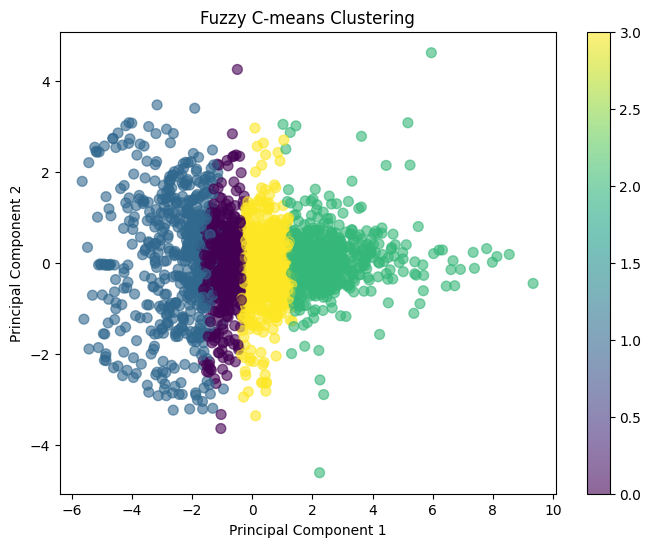

In [976]:
from sklearn.decomposition import PCA

# Reduce dimensions to 2D
pca = PCA(n_components=3)
data_2d = pca.fit_transform(data_array)

def plot_clusters(data_array, labels, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(data_array[:, 0], data_array[:, 1], c=labels, cmap='viridis', s=50, alpha=0.6)
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar()
    plt.show()

# Plot the reduced data
plot_clusters(data_2d, kmeans_labels, 'K-means Clustering')
plot_clusters(data_2d, hierarchical_labels, 'Hierarchical Clustering')
plot_clusters(data_2d, fcm_labels, 'Fuzzy C-means Clustering')


In [980]:
segment_customer['Cluster'] = kmeans_labels
display(segment_customer[:10])

,CustomerID,frequency,recency,T,monetary_value,expected_purc_1_month,expected_purc_3_month,retention,churn,expected_average_profit,expected_clv,weeksfrom_lastpurchase,sum,categ_0,categ_1,categ_2,categ_3,categ_4,Cluster
0,12347.00000,6.00000,365.00000,367.00000,599.70167,0.46942,1.87734,0.99834,0.00166,567.28212,1064.97927,2.00000,4310.00000,1273.19000,1136.80000,484.32000,518.99000,896.70000,1
1,12348.00000,3.00000,283.00000,358.00000,301.48000,0.26854,1.07401,0.99094,0.00906,331.74422,356.29585,75.00000,1797.24000,0.00000,754.00000,683.24000,360.00000,0.00000,3
2,12352.00000,5.00000,260.00000,296.00000,417.84200,0.47844,1.91336,0.99621,0.00379,415.66877,795.32410,36.00000,2385.71000,348.35000,374.68000,31.00000,1534.55000,97.13000,2
3,12356.00000,2.00000,303.00000,325.00000,269.90500,0.21503,0.85999,0.99123,0.00877,321.50361,276.48911,22.00000,2811.43000,204.00000,788.95000,397.75000,1066.83000,353.90000,2
4,12358.00000,1.00000,149.00000,150.00000,683.20000,0.24992,0.99946,0.94659,0.05341,531.73789,531.45106,1.00000,1168.06000,15.00000,74.16000,0.00000,1061.20000,17.70000,0
5,12359.00000,3.00000,274.00000,331.00000,1864.32667,0.28669,1.14659,0.99242,0.00758,1445.06469,1656.89287,57.00000,6140.48000,1164.30000,651.54000,156.36000,3456.20000,712.08000,1
6,12360.00000,2.00000,148.00000,200.00000,789.24000,0.31482,1.25900,0.98533,0.01467,644.94461,811.98756,52.00000,2662.06000,334.55000,519.82000,305.56000,810.35000,691.78000,1
7,12362.00000,9.00000,292.00000,295.00000,520.04222,0.80936,3.23663,0.99890,0.00110,506.59684,1639.66854,3.00000,5154.58000,1141.34000,1406.90000,279.70000,1198.40000,1128.24000,1
8,12363.00000,1.00000,133.00000,242.00000,252.90000,0.17592,0.70358,0.85729,0.14271,337.14754,237.20996,109.00000,552.00000,29.70000,207.00000,99.00000,47.70000,168.60000,2
9,12364.00000,3.00000,105.00000,112.00000,229.72667,0.63346,2.53301,0.99551,0.00449,280.62950,710.83619,7.00000,1313.10000,34.65000,431.28000,637.42000,159.60000,50.15000,2


**Radar Visual**

In [985]:
agg_df = segment_customer.groupby('Cluster').agg(
    count=('CustomerID', 'size'),
    expected_clv=('expected_clv', 'mean'),
    categ_0=('categ_0', 'mean'),
    categ_1=('categ_1', 'mean'),
    categ_2=('categ_2', 'mean'),
    categ_3=('categ_3', 'mean'),
    categ_4=('categ_4', 'mean')
)

display(agg_df[:10])

,count,expected_clv,categ_0,categ_1,categ_2,categ_3,categ_4
Cluster,,,,,,,
0,519,304.22193,121.66449,95.88857,30.46911,227.09555,94.31345
1,650,2479.59521,1545.52666,1949.71331,920.12929,1993.72277,2142.53994
2,1365,512.11851,230.22849,343.87486,181.42272,260.71606,289.50135
3,250,368.82784,24.07260,194.97508,192.74888,24.25604,245.25100


C:\Users\Admin\AppData\Local\Temp\ipykernel_13660\894852662.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


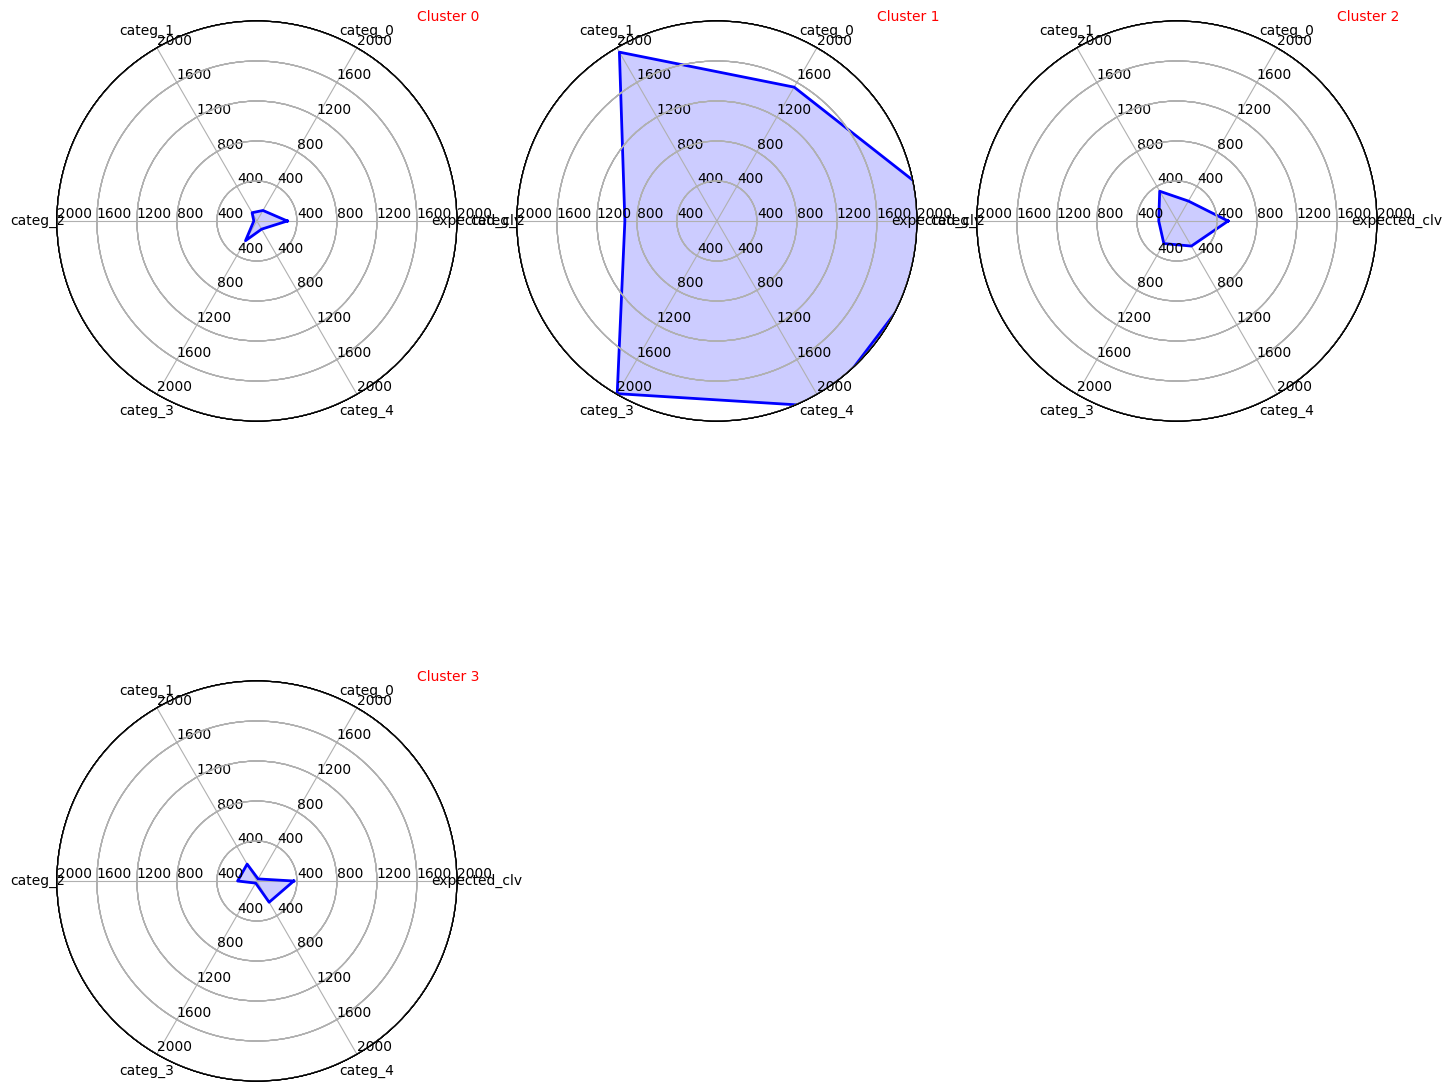

In [987]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels=6):
        # Setup radar chart
        angles = np.arange(0, 360, 360./len(variables))
        ix, iy = location[:]
        size_x, size_y = sizes[:]
        axes = [fig.add_axes([ix, iy, size_x, size_y], polar=True, label=f"axes{i}") for i in range(len(variables))]
        _, text = axes[0].set_thetagrids(angles, labels=variables)
        for txt, angle in zip(text, angles):
            txt.set_rotation(angle - 90 if angle > -1 and angle < 181 else angle - 270)
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i], num=n_ordinate_levels)
            grid_label = [""] + [f"{x:.0f}" for x in grid[1:]]
            ax.set_rgrids(grid, labels=grid_label, angle=angles[i])
            ax.set_ylim(*ranges[i])
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]

    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)

    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform=self.ax.transAxes, *args, **kw)

fig = plt.figure(figsize=(12, 12))

attributes = [ 'expected_clv', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']

ranges = [
    (0, 2000),
    (0, 2000),
    (0, 2000),
    (0, 2000),
    (0, 2000),
    (0, 2000),
    (0, 2000)
]

index = agg_df.index.tolist()
n_clusters = len(index)
i_cols = 3
i_rows = (n_clusters // i_cols) + (n_clusters % i_cols > 0)

size_x, size_y = (1 / i_cols), (1 / i_rows)

for ind in range(n_clusters):
    ix = ind % i_cols
    iy = i_rows - ind // i_cols - 1
    pos_x = ix * (size_x + 0.05)
    pos_y = iy * (size_y + 0.05)
    location = [pos_x, pos_y]
    sizes = [size_x, size_y]
    
    if index[ind] in agg_df.index:
        data = np.array(agg_df.loc[index[ind], attributes])
        radar = RadarChart(fig, location, sizes, attributes, ranges)
        radar.plot(data, color='b', linewidth=2.0)
        radar.fill(data, alpha=0.2, color='b')
        radar.title(title=f'Cluster {index[ind]}', color='r')
    else:
        print(f"Index {index[ind]} not found in `agg_df`.")

plt.tight_layout()
plt.show()